In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Commençons par regarder les données

In [3]:
data = pd.read_csv('winequality-red.csv', sep=";")
print(data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

Nos données contiennent 11 colonnes, 10 qui correspondent à divers indicateurs physico-chimiques et 1 qui est la qualité du vin.


In [4]:
#Nous allons extraire deux arrays numpy de ces données, 
#un qui contient les points et l’autre qui contient les étiquettes

X = data[data.columns[:-1]].values
y = data['quality'].values

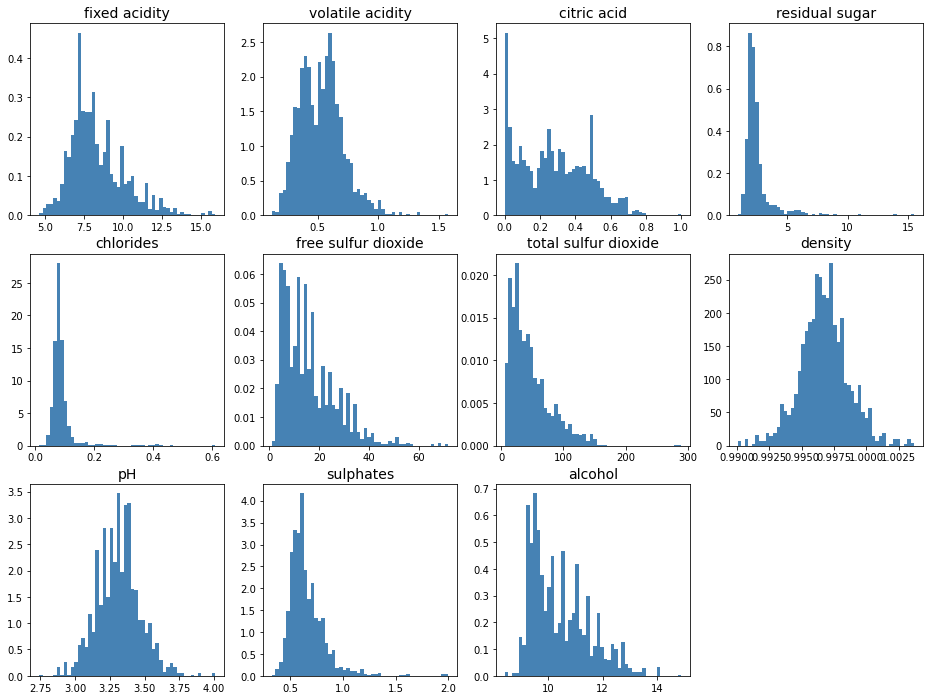

In [5]:
#On peut maintenant afficher un histogramme pour chacune de nos variables :

fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

On remarque en particulier que ces variables prennent des valeurs dans des ensembles différents. Par exemple, “sulphates” varie de 0 à 1 tandis que “total sulfur dioxide” varie de 0 à 440. Il va donc nous falloir standardiser les données pour que la deuxième ne domine pas complètement la première.

# SELECTION DE MODELE

In [7]:
#Nous allons commencer par transformer ce problème en un problème de classification : il s’agira de séparer les bons vins des vins médiocres :

y_class = np.where(y<6, 0, 1)

In [8]:
#Séparons nos données en un jeu d’entraînement et un jeu de test. Le jeu de test contiendra 30% des données.

from sklearn import model_selection
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y_class,
                                    test_size=0.3 # 30% des données dans le jeu de test
                                    )

In [9]:
#Nous pouvons maintenant standardiser les données d’entraînement et appliquer la même transformation aux données de test :

from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

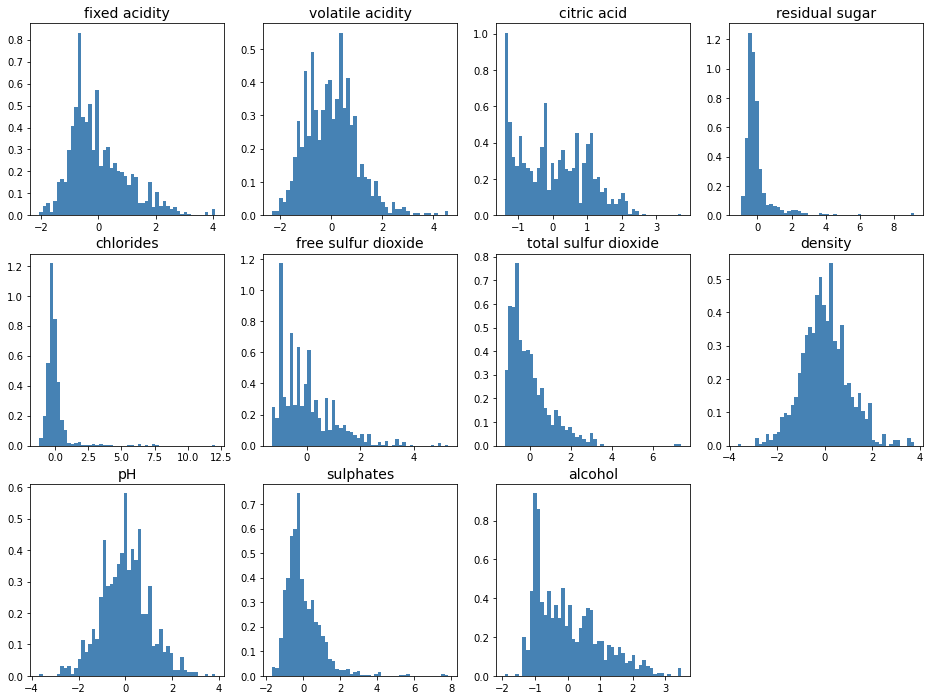

In [10]:
#On peut visualiser de nouveau les données pour vérifier que les différentes variables prennent des valeurs qui ont maintenant des ordres de grandewur similaires.

fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

### Nous allons maintenant utiliser la méthode "GridSearchCV" pour faire une validation croisée du paramètre k d’un kNN (le nombre de plus proches voisins) sur le jeu d’entraînement :

In [11]:

from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['std_test_score'],  # écart-type du score
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )



Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 15}
Résultats de la validation croisée :
accuracy = 0.727 (+/-0.052) for {'n_neighbors': 3}
accuracy = 0.718 (+/-0.043) for {'n_neighbors': 5}
accuracy = 0.730 (+/-0.053) for {'n_neighbors': 7}
accuracy = 0.735 (+/-0.050) for {'n_neighbors': 9}
accuracy = 0.737 (+/-0.050) for {'n_neighbors': 11}
accuracy = 0.741 (+/-0.033) for {'n_neighbors': 13}
accuracy = 0.744 (+/-0.039) for {'n_neighbors': 15}


La meilleure performance (~0.744) est ici atteinte avec 15 voisins.


In [12]:

#Nous pouvons maintenant regarder la performance sur le jeu de test.
#GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement

y_pred = clf.predict(X_test_std)
print("\nSur le jeu de test : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))



Sur le jeu de test : 0.715


### UTILISER UNE COURBE ROC

Text(0, 0.5, 'Sensibilite')

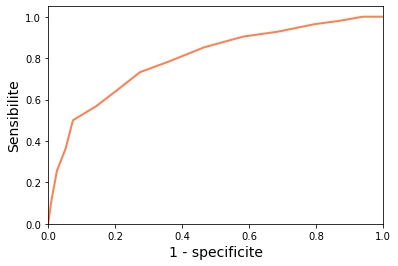

In [13]:
#Traçons la courbe ROC du kNN

y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)

On peut résumer la courbe ROC par un nombre : "l'aire sous la courbe", aussi dénotée AUROC pour « Area Under the ROC », qui permet plus aisément de comparer plusieurs modèles.

Un classifieur parfait a une AUROC de 1 ; un classifieur aléatoire, une AUROC de 0.5



In [14]:
#Revenons à l’exemple du vin portugais : l’aire sous la courbe ROC peut être calculée par :

print(metrics.auc(fpr, tpr))

0.7972608695652175


Prenons l’exemple du vinho verde. Imaginons que l’algorithme doit être capable de détecter efficacement les vins de mauvaise qualité, qui ne seront pas ensuite examinés par un expert humain. On veut alors limiter le nombre de faux négatifs, pour limiter le nombre de rejets infondés. Fixons-nous un taux de faux négatifs tolérable (la proportion de positifs incorrectement prédits négatifs) de 5%. Cela équivaut à une sensibilité de 0.95 :


## FNR=FN/(#pos) = FNTP+FN = 1−TPTP+FN = 1−sensibilité


In [15]:
# indice du premier seuil pour lequel
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95)) 

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1-fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))

Sensibilité : 0.96
Spécificité : 0.20
Seuil : 0.27
